# Benchmark QRT

This notebook illustrates a simple benchmark example that should help novice participants to start the competition.

## Used libraries

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [5]:
x_train = pd.read_csv('C:\\Users\\aryje\\OneDrive\\Stalinis kompiuteris\\Durhack\\x_train.csv', index_col='ID')
y_train = pd.read_csv('C:\\Users\\aryje\\OneDrive\\Stalinis kompiuteris\\Durhack\\y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('C:\\Users\\aryje\\OneDrive\\Stalinis kompiuteris\\Durhack\\x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [6]:
x_train.VOLUME_1.isna().value_counts()

False    353570
True      65025
Name: VOLUME_1, dtype: int64

## Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

The following cell computes statistics on a given target conditionally to some features. For example, we want to generate a feature that describe the mean of `RET_1` conditionally to the `SECTOR` and the `DATE`.

**Ideas of improvement**: change shifts, the conditional features, the statistics, and the target. 

In [12]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [10] # Choose some different shifts
statistics = ['mean', 'std']  # the type of stat
gb_features = ['SECTOR', 'DATE', 'INDUSTRY']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [13]:
target = 'RET'

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_1_SECTOR_DATE_INDUSTRY_mean,RET_1_SECTOR_DATE_INDUSTRY_std,RET_1_SECTOR_DATE_INDUSTRY_var,RET_2_SECTOR_DATE_INDUSTRY_mean,RET_2_SECTOR_DATE_INDUSTRY_std,...,RET_6_SECTOR_DATE_INDUSTRY_var,RET_7_SECTOR_DATE_INDUSTRY_mean,RET_7_SECTOR_DATE_INDUSTRY_std,RET_7_SECTOR_DATE_INDUSTRY_var,RET_8_SECTOR_DATE_INDUSTRY_mean,RET_8_SECTOR_DATE_INDUSTRY_std,RET_8_SECTOR_DATE_INDUSTRY_var,RET_9_SECTOR_DATE_INDUSTRY_mean,RET_9_SECTOR_DATE_INDUSTRY_std,RET_9_SECTOR_DATE_INDUSTRY_var
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.008289,0.017973,0.000323,-0.049532,0.025860,...,0.000537,-0.027328,0.017969,0.000323,0.016106,0.018315,0.000335,0.035409,0.040152,0.001612
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,0.000671,0.026857,0.000721,-0.031111,0.043367,...,0.002849,-0.009863,0.033060,0.001093,0.010774,0.041196,0.001697,0.020720,0.047346,0.002242
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,0.012713,0.031950,0.001021,-0.040947,0.035705,...,0.001518,-0.019393,0.028273,0.000799,0.009290,0.032437,0.001052,0.033698,0.052335,0.002739
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,0.030315,0.022465,0.000505,0.005078,0.021199,...,0.000154,-0.028122,0.016970,0.000288,0.016885,0.012985,0.000169,0.006445,0.020235,0.000409
4,0.027273,-0.039302,0.000000,0.000000,0.022321,0.004413,0.012243,0.000150,-0.013324,0.027496,...,0.000210,-0.002842,0.016459,0.000271,-0.004381,0.011274,0.000127,0.005674,0.020044,0.000402


In [14]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

cle_params = {
    "verbose": True
}

def cle_training():
    clf1 = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1, random_state=0)
    clf2 = LogisticRegressionCV(random_state=0)
    clf3 = GaussianNB()
    clf4 = KNeighborsClassifier()
    clf5 = GradientBoostingClassifier(random_state=0)

    # return VotingClassifier(
    #     estimators=[('rf', clf1), ('lr', clf2), ('gnb', clf3), ('svc', clf4), ('ada', clf5)],
    #     voting="soft",
    #     verbose=True
    # )
    return GradientBoostingClassifier(
        random_state=0, 
        verbose=True, 
        learning_rate=.05,
        max_depth=2,
        warm_start=True,
        tol=1e-3,
        n_estimators=50
    )
    # return MLPClassifier(
    #     verbose=True,
    #     hidden_layer_sizes=128
    # )

## Model and local score

A Random Forest (RF) model is chosen for the Benchmark. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [15]:
X_train = train[features]
y_train = train[target]

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    
    # model = RandomForestClassifier(**rf_params)
    model = cle_training()
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

      Iter       Train Loss   Remaining Time 
         1           1.3861            1.62m
         2           1.3860            1.64m
         3           1.3858            1.63m
         4           1.3857            1.46m
         5           1.3856            1.40m
         6           1.3854            1.31m
         7           1.3853            1.22m
         8           1.3852            1.16m
         9           1.3851            1.11m
        10           1.3851            1.06m
        20           1.3842           43.94s
        30           1.3835           28.37s
        40           1.3828           14.01s
        50           1.3823            0.00s
Fold 1 - Accuracy: 50.30%
      Iter       Train Loss   Remaining Time 
         1           1.3861            1.14m
         2           1.3860            1.19m
         3           1.3859            1.14m
         4           1.3858            1.10m
         5           1.3856            1.08m
         6           1.3855

KeyboardInterrupt: 

<AxesSubplot:>

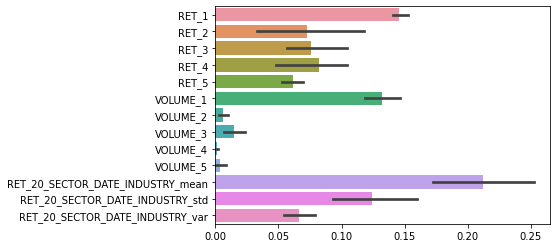

In [19]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h')

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [ ]:
X_test = test[features]

rf_params['random_state'] = 0
model = train()
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('C:\\Users\\aryje\\OneDrive\\Stalinis kompiuteris\\Durhack\\QRT-Stock-Return-Prediction\\Durhackbenchmark_qrt.csv', index=True, header=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min


KeyboardInterrupt: 


The local accuracy is around 51. If we did not overfit, we shall expect something within the range above.

After submitting the benchmark file at https://challengedata.ens.fr, we obtain a public score of 51.31 %.